In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)


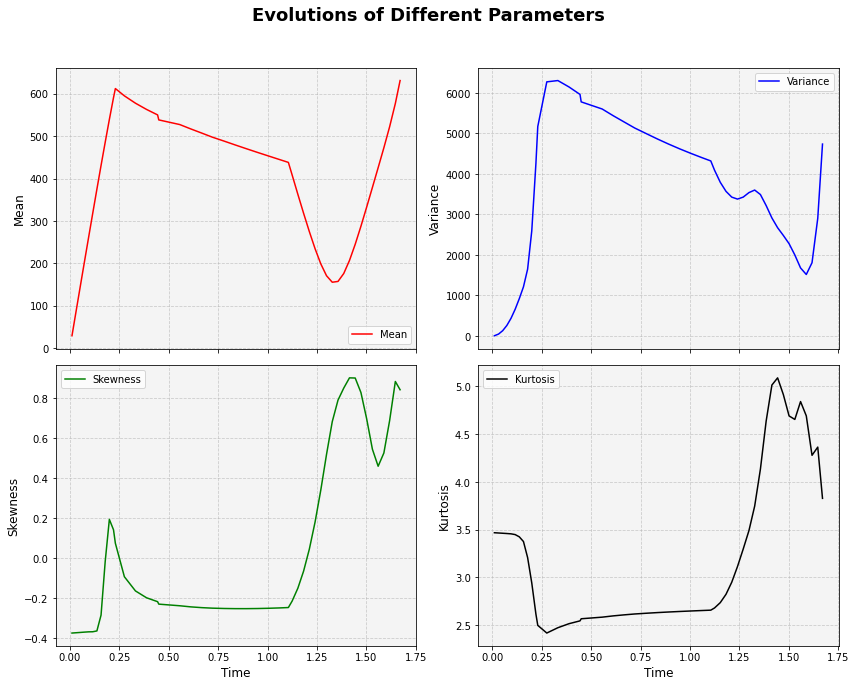

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# Plot Mean
axs[0, 0].plot(tExp, xExp[:, 0], 'r', label='Mean')
axs[0, 0].set_ylabel("Mean", fontsize=12)
axs[0, 0].legend()
axs[0, 0].set_facecolor('#F4F4F4')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Variance
axs[0, 1].plot(tExp, xExp[:, 1], 'b', label='Variance')
axs[0, 1].set_ylabel("Variance", fontsize=12)
axs[0, 1].legend()
axs[0, 1].set_facecolor('#F4F4F4')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot Skewness
axs[1, 0].plot(tExp, xExp[:, 2], 'g', label='Skewness')
axs[1, 0].set_xlabel("Time", fontsize=12)
axs[1, 0].set_ylabel("Skewness", fontsize=12)
axs[1, 0].legend()
axs[1, 0].set_facecolor('#F4F4F4')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot Kurtosis
axs[1, 1].plot(tExp, xExp[:, 3], 'k', label='Kurtosis')
axs[1, 1].set_xlabel("Time", fontsize=12)
axs[1, 1].set_ylabel("Kurtosis", fontsize=12)
axs[1, 1].legend()
axs[1, 1].set_facecolor('#F4F4F4')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Customize the overall appearance
fig.suptitle("Evolutions of Different Parameters", fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to prevent clipping

# Show the plot
plt.show()


In [22]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]


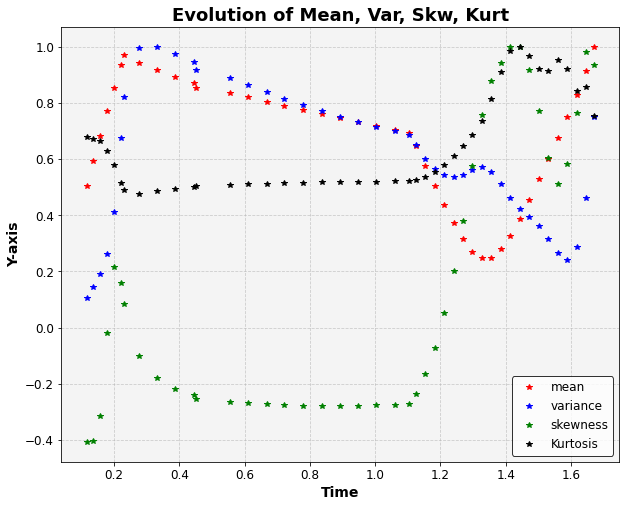

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tExpTrunc,xExpTruncNormal[:,0], 'r*',label='mean')

plt.plot(tExpTrunc,xExpTruncNormal[:,1], 'b*',label='variance')

plt.plot(tExpTrunc,xExpTruncNormal[:,2], 'g*',label='skewness')

plt.plot(tExpTrunc,xExpTruncNormal[:,3], 'k*',label='Kurtosis')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("Time", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

# Show the plot
plt.show()


In [24]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [25]:
from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
quad_interp = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
xTrain = quad_interp(tTrain) 

In [26]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

In [27]:
clear true_y 

In [28]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

In [29]:
# s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
# batch_y0 = true_y[s]  # (M, D)
# batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
# batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
# batch_y=batch_y.permute(2,0,1,3)

In [30]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [31]:
## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncVariance(nn.Module):

#     def __init__(self):
#         super(ODEFuncVariance, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcVariance = ODEFuncVariance().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncSkewness(nn.Module):

#     def __init__(self):
#         super(ODEFuncSkewness, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcSkewness = ODEFuncSkewness().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncKurtosis(nn.Module):

#     def __init__(self):
#         super(ODEFuncKurtosis, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcKurtosis = ODEFuncKurtosis().to(device)
    
def combined_system(tVar, y):
    # global t
    # global dmeanBydt
    # print(tVar.item())
    # dt_dt = 1.0
    # dt_dt = torch.tensor([dt_dt])
    # dm_dt = 1.0
    # dm_dt = torch.tensor([dm_dt])
    # dk_dt = dm_dt
    # dv_dt = dm_dt
    # ds_dt = dm_dt
    

    #indexTemp = np.where(t== tVar)[0].item()
    
    # dt_dt = 1.0
    # dt_dt = torch.tensor([dt_dt])
    
    # dm_dt = funcMean(tVar, y)
    
    # dv_dt = dvarBydt[indexTemp];
    # dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)

    # ds_dt = dskwBydt[indexTemp];
    # ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)

    # dk_dt = dkurtBydt[indexTemp];
    # dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])
    
    dm_dt = funcMean(tVar, y)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
    
    ds_dt = ds_dt_fun(tVar.item()).item()
    ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [32]:
# Mean
parvalue = 0;

In [34]:
batch_t[0,0] 

tensor(1.3604, dtype=torch.float64)

In [35]:
batch_y0[0,0]

tensor([0.2525, 0.5486, 0.8892, 0.8262, 1.3604], dtype=torch.float64)

In [43]:
for ic in batch_y0:
    print(ic.dtype)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.

In [44]:
ic[0]

tensor([0.2707, 0.5614, 0.5770, 0.6857, 1.2981], dtype=torch.float64)

In [45]:
funcMean( batch_t[temp1,0],ic[0])

tensor([0.0011], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [46]:
ii = 0
## Setting up the optimizer

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(funcMean.parameters(), lr=0.005)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,0].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,0]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,0].unsqueeze(1)
                actual_toDisplay = true_y[:,:,0]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 1.772605
Iter 0020 | Total Loss 0.633685
Iter 0040 | Total Loss 0.415446
Iter 0060 | Total Loss 0.353878
Iter 0080 | Total Loss 2.200605
Iter 0100 | Total Loss 1.751975
Iter 0120 | Total Loss 2.583086
Iter 0140 | Total Loss 1.834795
Iter 0160 | Total Loss 1.418484
Iter 0180 | Total Loss 1.466153
Iter 0200 | Total Loss 0.358763
Iter 0220 | Total Loss 0.526107
Iter 0240 | Total Loss 0.871721
Iter 0260 | Total Loss 1.706804
Iter 0280 | Total Loss 2.744620
Iter 0300 | Total Loss 1.588985
Iter 0320 | Total Loss 2.311689
Iter 0340 | Total Loss 1.519315
Iter 0360 | Total Loss 0.731872
Iter 0380 | Total Loss 0.043535
Iter 0400 | Total Loss 1.673900
Iter 0420 | Total Loss 1.357462
Iter 0440 | Total Loss 0.412727
Iter 0460 | Total Loss 0.420265
Iter 0480 | Total Loss 0.342586
Iter 0500 | Total Loss 0.165372
Iter 0520 | Total Loss 0.175699
Iter 0540 | Total Loss 0.046763
Iter 0560 | Total Loss 0.613459
Iter 0580 | Total Loss 0.364906
Iter 0600 | Total Loss 0.139954
Iter 062

KeyboardInterrupt: 

In [50]:
optimizer = optim.RMSprop(funcMean.parameters(), lr=0.001)

for itr in range(1240, 2000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,0].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,0]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,0].unsqueeze(1)
                actual_toDisplay = true_y[:,:,0]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 1240 | Total Loss 0.403652
Iter 1260 | Total Loss 0.011682
Iter 1280 | Total Loss 0.022134
Iter 1300 | Total Loss 0.021789
Iter 1320 | Total Loss 0.021870
Iter 1340 | Total Loss 0.023493
Iter 1360 | Total Loss 0.022398
Iter 1380 | Total Loss 0.036031
Iter 1400 | Total Loss 0.023304
Iter 1420 | Total Loss 0.021877
Iter 1440 | Total Loss 0.045270
Iter 1460 | Total Loss 0.018708
Iter 1480 | Total Loss 0.022961
Iter 1500 | Total Loss 0.022316
Iter 1520 | Total Loss 0.022153
Iter 1540 | Total Loss 0.016866
Iter 1560 | Total Loss 0.034272
Iter 1580 | Total Loss 0.010552
Iter 1600 | Total Loss 0.049341
Iter 1620 | Total Loss 0.034883
Iter 1640 | Total Loss 0.028271
Iter 1660 | Total Loss 0.014774
Iter 1680 | Total Loss 0.038520
Iter 1700 | Total Loss 0.028952
Iter 1720 | Total Loss 0.021156
Iter 1740 | Total Loss 0.016150
Iter 1760 | Total Loss 0.040137
Iter 1780 | Total Loss 0.019059
Iter 1800 | Total Loss 0.010172
Iter 1820 | Total Loss 0.018079
Iter 1840 | Total Loss 0.015062
Iter 186

NameError: name 'temp_x_t_m_p2' is not defined

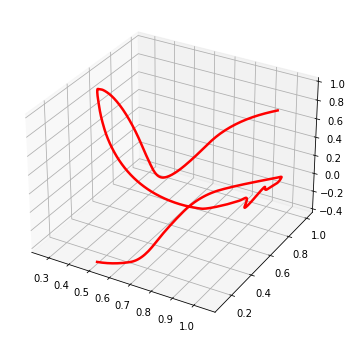

In [53]:
# Assuming ODEFunc is the name of your neural network class
modelMean = funcMean
# modelVar = funcVariance
# modelSkw = funcSkewness
# modelKurt = funcKurtosis


modelMean.eval()
# modelVar.eval()
# modelSkw.eval()
# modelKurt.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 0], predicted_states[:, 1], predicted_states[:, 2], "r", label="$Neural-ODE-model$", linewidth=2.5,alpha =1)
ax.plot(temp_x_t_m_p2[:, 0], temp_x_t_m_p2[:, 1], temp_x_t_m_p2[:, 2], "b", label="True value", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

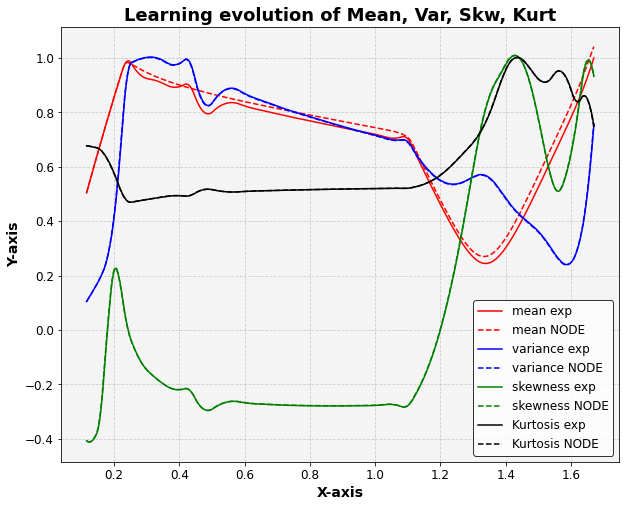

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrain[:,0], 'r',label='mean exp')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain,xTrain[:,1], 'b',label='variance exp')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tTrain,xTrain[:,2], 'g',label='skewness exp')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain,xTrain[:,3], 'k',label='Kurtosis exp')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('NN_Mean_all_parts.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [56]:
torch.save(funcMean, 'mean.pth')

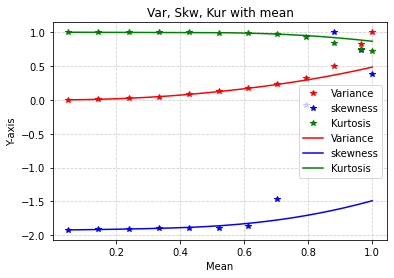

In [29]:
# Create a plot with different labels for each column
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 1], 'r*',label='Variance')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 2], 'b*',label='skewness')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 3], 'g*',label='Kurtosis')

plt.plot(t, predicted_states[:, 1], 'r',label='Variance')
plt.plot(t, predicted_states[:, 2], 'b',label='skewness')
plt.plot(t, predicted_states[:, 3], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

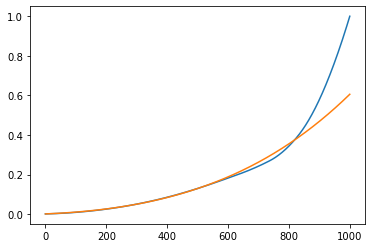

In [21]:
plt.plot(x_t_m_p1[:,1])
plt.plot(predicted_states[:,1])

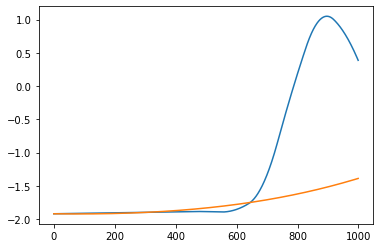

In [22]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

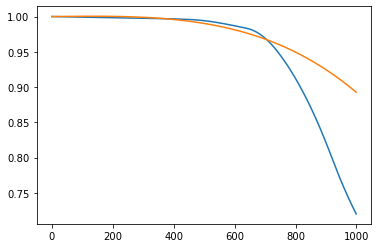

In [24]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])

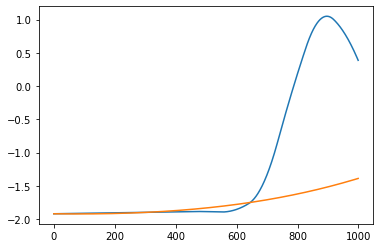

In [18]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

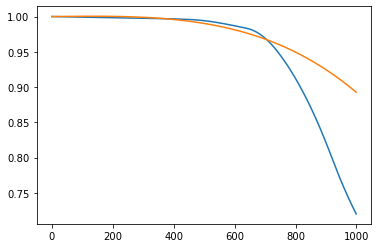

In [19]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])